In [11]:
import numpy as np
from matplotlib import pyplot as plt
import json
from tqdm.notebook import tqdm
import sys
import corner
import matplotlib.image as mpimg

import matplotlib as mpl

sys.path.append("../")

import tdpy_mod as tdpy

from binary_planets.sim import get_hill_radius

%load_ext autoreload
%autoreload 2

%matplotlib inline


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
def gen_arr(config, bin=True, n=12000, secondary=True, extra_keys = []):
    n_secondary = config["n_secondary"]
    
    if secondary == "sin_inj":
        sec = 1
    elif secondary:
        sec = n_secondary
    
    l = bin*len(config["binary"].keys()) + sec*len(config["secondary_0"].keys()) + 2 + len(extra_keys)
    arr = np.zeros((n, l))*np.nan
    keys = []
    keys.append("stable")
    keys.append("m_star")

    if secondary == "sin_inj":
        for key in config["secondary_0"].keys():
            keys.append(f"{0}/{key}")
    elif secondary:
        for i in range(0, n_secondary):
            for key in config["secondary_0"].keys():
                keys.append(f"{i}/{key}")
    if bin:
        for key in config["binary"].keys():
            keys.append(f"bin/{key}")
    
    for key in extra_keys:
        keys.append(key)
    
    return arr, keys




def add_to_array(arr, config, keys, i, stable, bin=True, n=12000, secondary=True, extra_keys=[], extra_vars=[]):
    if not np.any(arr):
        arr, keys = gen_arr(config, bin=bin, n=n, secondary=secondary, extra_keys=extra_keys)
        
    n_secondary = config["n_secondary"]
    arr[i, 0] = stable

    arr[i, 1] = config["m_star"]
    
    inj = n_secondary-1
    
    j = 2
    if secondary == "sin_inj":
        for key in config["secondary_0"].keys():
            arr[i, j] = config[f"secondary_{inj}"][key]
            j += 1
    elif secondary:
        for k in range(0, n_secondary):
            for key in config["secondary_0"].keys():
                arr[i, j] = config[f"secondary_{k}"][key]
                j += 1
    if bin:
        for key in config["binary"].keys():
            arr[i, j] = config["binary"][key]
            j += 1
    for k in range(len(extra_keys)):
        arr[i, j] = extra_vars[k]
        j += 1
    
    return arr, keys
    

In [33]:

run_systems = np.load("../data/compact_systems_run_composite.npy", allow_pickle=True)
all_names = names = [sys["name"] for sys in run_systems if sys["name"]]
names = [sys["name"] for sys in run_systems if sys["name"] not in ["Kepler-324", "Kepler-341"]]
# names = ["Kepler-186"]

is_binary = False

dir = "sin_inj"

extra_keys = ["a_f", "max_change"]

arr_t = None
stable_t = None
stable_omega = []
unstable_omega = []
for system in tqdm(names):
    cached_data =  np.load(f"../output/{dir}/{system}/collated_results.npz", allow_pickle=True)
    cached_summaries = cached_data["summaries"]
    cached_cfgs = cached_data["cfgs"]
    cached_elements = cached_data["elements"]
    cached_distances = cached_data["distances"]
    n = len(cached_summaries)
    
    for _ in range(1):
#     try:
        arr = None
        keys = None
        system_idx = np.where(np.array(all_names) == system)[0][0]


        j = 0
        stable = np.zeros(n)

        for i in range(0, n):
#             try:
              for _ in range(1):
#                 with open(f"../output/{dir}/{system}/{i}/config.json") as f:
#                     cfg = json.load(f)
#                     elements = np.load(f"../output/{dir}/{system}/{i}/elements.npy")
#                     distances = np.load(f"../output/{dir}/{system}/{i}/distances.npy")
                cfg = cached_cfgs[i]
                elements = cached_elements[i]
#                 distances = cached_distances[i]
    
                n_inj = cfg["n_secondary"] - 1

                a_i = elements[0, :, 0]
                a_f = elements[-1, :, 0]

                stable[i] = np.all(((a_i-a_f)/a_i) < 0.1)


                
                if is_binary:
                    bin_e = cfg["binary"]["e"]
                    bin_a = a_i[1]
                    max_d = 1.1 * bin_a * (1 + bin_e)
                    if np.any(distances > max_d):
                        stable[i] = False


                # stable[i] = cfg["secondary_0"]["omega"] < 0

                arr, keys = add_to_array(arr, 
                                         cfg, 
                                         keys,
                                         j, 
                                         stable[i], 
                                         bin=is_binary, 
                                         secondary="sin_inj",
                                         extra_keys=extra_keys,
                                         extra_vars=[elements[-1, n_inj, 0], np.nanmax((a_i-a_f)/a_i)]
                                        )

#                 print(stable[i])
                if stable[i]:
                    stable_omega.append(cfg["secondary_0"]["omega"])
                else:
                    unstable_omega.append(cfg["secondary_0"]["omega"])
                j += 1

#             except Exception as e:
#                 print("Exception!:", e)
#                 pass
        arr = arr[:j, :]
        stable = stable[:j]
        stable = np.logical_not(np.logical_not(stable))
        keys = np.array(keys)
        arr[:, 1:] += np.random.random((arr.shape[0], arr.shape[1]-1)) * 1e-20


#         m_tot = arr[:, keys=="bin/m1"] + arr[:, keys=="bin/m2"]
#         q = arr[:, keys=="bin/m1"] / m_tot
#         arr[:, keys=="bin/m1"] = m_tot
#         arr[:, keys=="bin/m2"] = q
#         keys[keys=="bin/m1"] = "bin/m_tot"
#         keys[keys=="bin/m2"] = "bin/q"

#         hill_radius = get_hill_radius(arr[:, keys=="bin/a"], 
#                                       arr[:, keys=="bin/e_sys"], 
#                                       arr[:, keys=="bin/m_tot"], 
#                                       arr[:, keys=="m_star"])
#         arr[:, keys=="bin/d"] /= hill_radius

        arr[:, keys=="0/a"] = ((np.log10(arr[:, keys=="0/a"]) - np.log10(run_systems[system_idx]["gap"][0]))
                                 / (np.log10(run_systems[system_idx]["gap"][1]) - np.log10(run_systems[system_idx]["gap"][0])))

        arr[:, keys=="a_f"] = ((np.log10(arr[:, keys=="a_f"]) - np.log10(run_systems[system_idx]["gap"][0]))
                             / (np.log10(run_systems[system_idx]["gap"][1]) - np.log10(run_systems[system_idx]["gap"][0])))

    
        if not np.any(arr_t):
            arr_t = arr
            stable_t = stable
        else:
            arr_t = np.vstack([arr_t, arr])
            stable_t = np.hstack([stable_t, stable])
#     except Exception as e:
#         print("Exception (lvl 2):", e)

  0%|          | 0/64 [00:00<?, ?it/s]

/tmp/554760.tmpdir/ipykernel_196/3013713122.py:72: RuntimeWarning: All-NaN slice encountered
  extra_vars=[elements[-1, n_inj, 0], np.nanmax((a_i-a_f)/a_i)]


In [34]:
np.sum(stable_t), np.sum(~stable_t)

(1052, 187135)

In [37]:
keys

array(['stable', 'm_star', '0/m', '0/a', '0/e', '0/inc', '0/omega',
       '0/Omega', 'a_f', 'max_change'], dtype='<U10')

In [38]:
# plt.style.use("dark_background")
mpl.rc("font", size=18)


# idxs = np.array(["e" in key for key in keys])
# idxs = np.array([("stable" not in key) for key in keys])

good_keys = ['0/m', '0/a', '0/e', '0/inc', "a_f", "max_change"]

idxs = np.array([(key in good_keys) for key in keys])


param_labels = np.char.replace(np.array(keys)[idxs], "_", "-")



# labels of the populations
listlablpopl = ['stable', 'not stable']

# number of populations
numbpopl = len(listlablpopl)


# number of features
numbfeat = np.sum(idxs)

param_labels = [ "m_pl", "a", "e", "inc", "a_f", "max_change"]


# labels of the parameters
listlablpara = []
for k in range(numbfeat):
#     listlablpara.append([param_labels[k][4:], ''])
    listlablpara.append([param_labels[k], ''])

    
typepgrp = 'both'
    
listcolrpopl = ["lime", "dimgray"]
    
# tdpy.plot_grid( 
#                np.array(listlablpara),
#      arr_t[arr_t[:, 0]==0, :][: ,idxs],
#      listlablpopl=listlablpopl, typeplottdim='scat', boolplottria=True,
#                pathbase=f"../figs/corner/prior", listcolrpopl=["gray"])

# tdpy.plot_grid( 
#                np.array(listlablpara),
#     arr_t[arr_t[:, 0]==1, :][: ,idxs],
#      listlablpopl=listlablpopl, typeplottdim='best', boolplottria=True,
#                pathbase=f"../figs/corner/surviving")

tdpy.plot_grid( 
               np.array(listlablpara),
    [arr_t[arr_t[:, 0]==1, :][: ,idxs], arr_t[: ,idxs]],
     listlablpopl=listlablpopl, typeplottdim='best', boolplottria=True,
               pathbase=f"../figs/corner/sin_inj", boolmakelegd=False, listcolrpopl=listcolrpopl)
# plt.savefig("../figs/corner.pdf")
plt.show()

tdpy.util.plot_grid():
boolplotpies
True
Number of samples in population 1 (not stable): 1052
Number of samples in population 0 (stable): 188187
tdpy.plot_grid(): 187131 out of 188187 samples (99.4%) are not finite for population 1 (not stable), parameter 4 (a_f)!
tdpy.plot_grid(): 187131 out of 188187 samples (99.4%) are not finite for population 1 (not stable), parameter 5 (max_change)!
Writing to ../figs/corner/sin_injpmar_None_scatscat.png...


In [17]:
listlablpara

[['m_pl', ''], ['a', ''], ['e', ''], ['inc', '']]

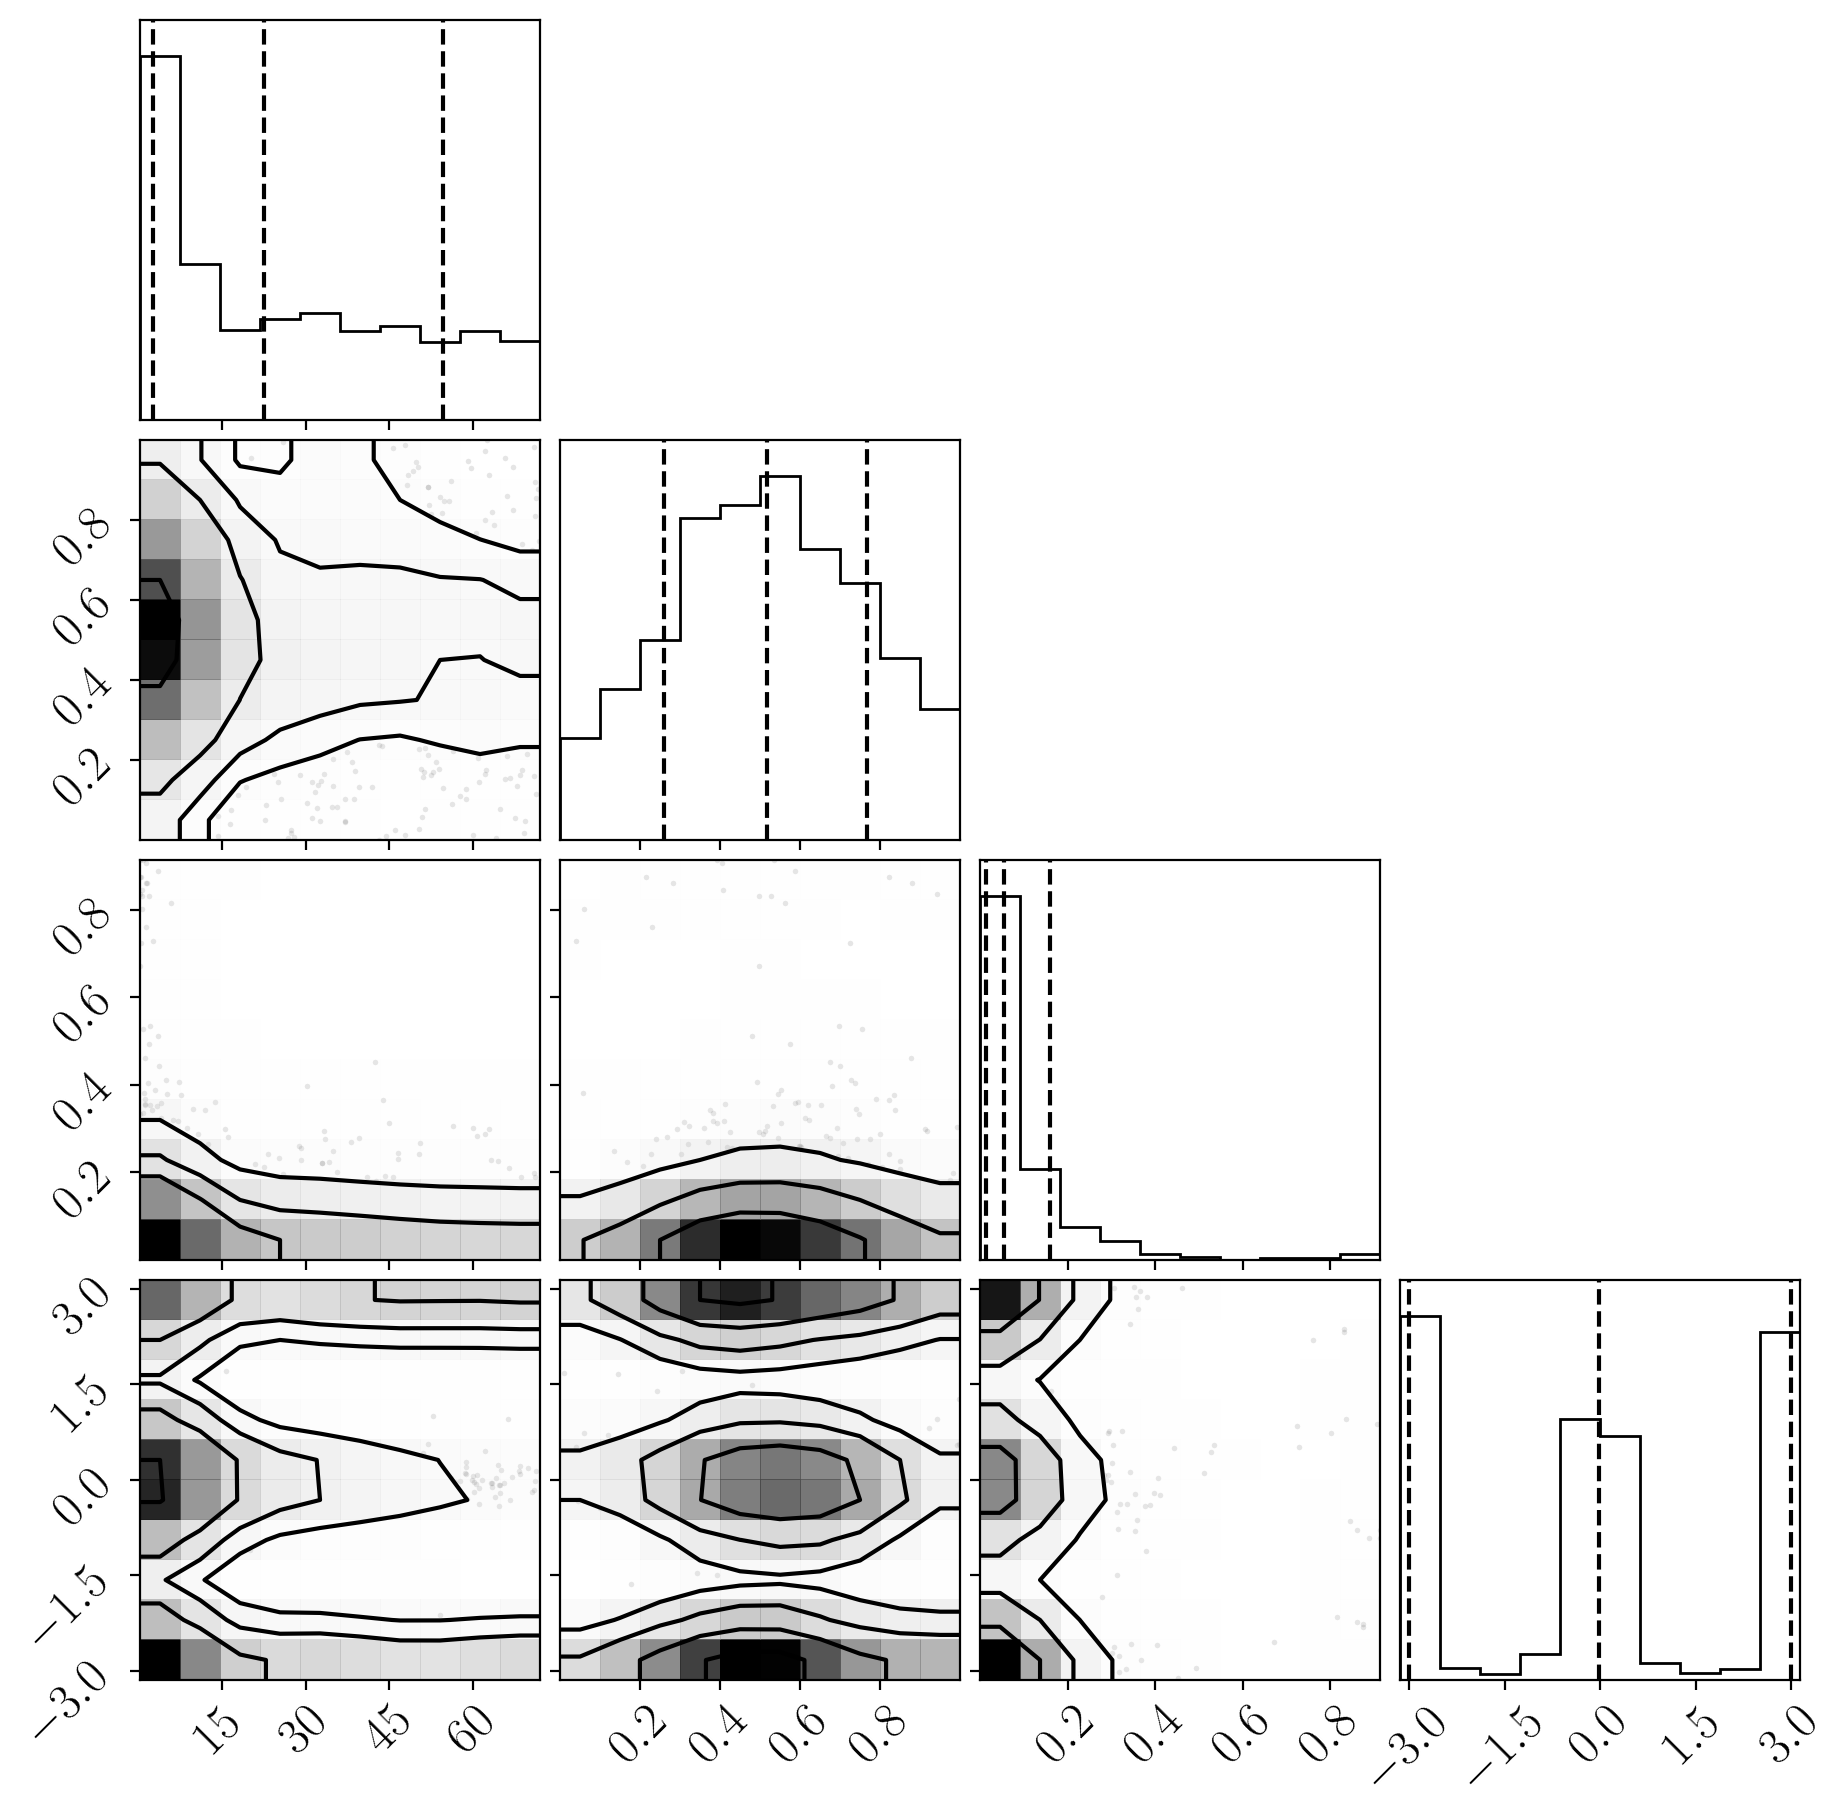

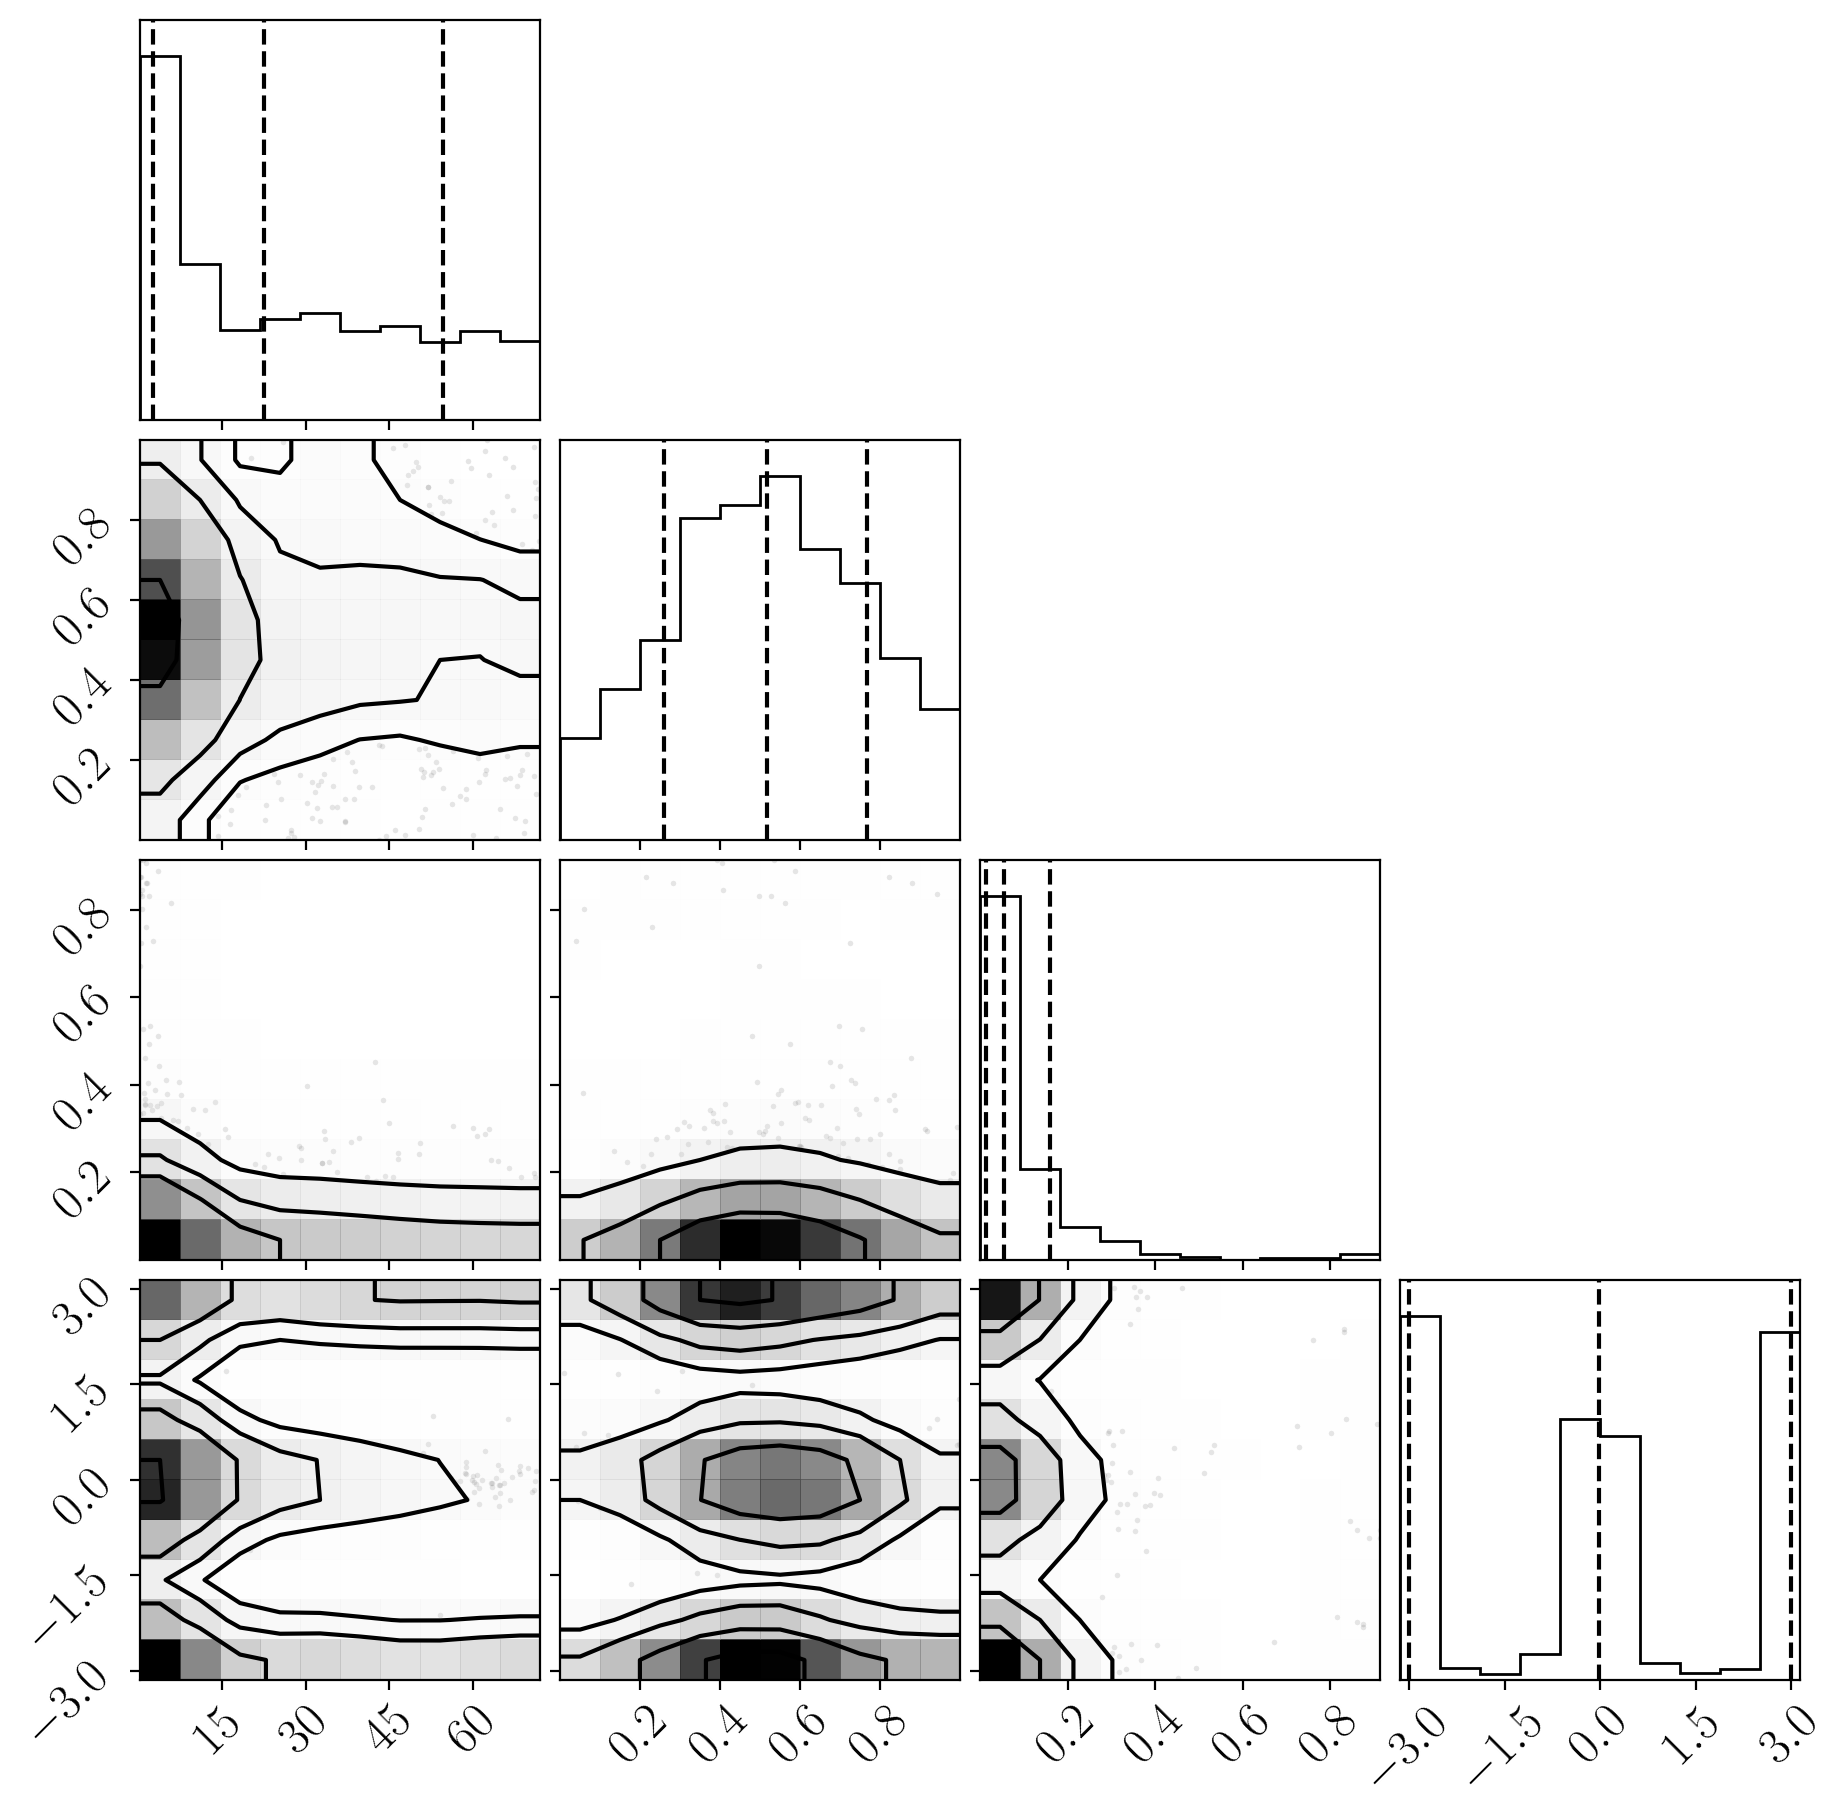

In [18]:
corner.corner(arr_t[arr_t[:, 0]==1, :][: ,idxs], bins=10, smooth=1,
             quantiles=[0.16, 0.5, 0.84])

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

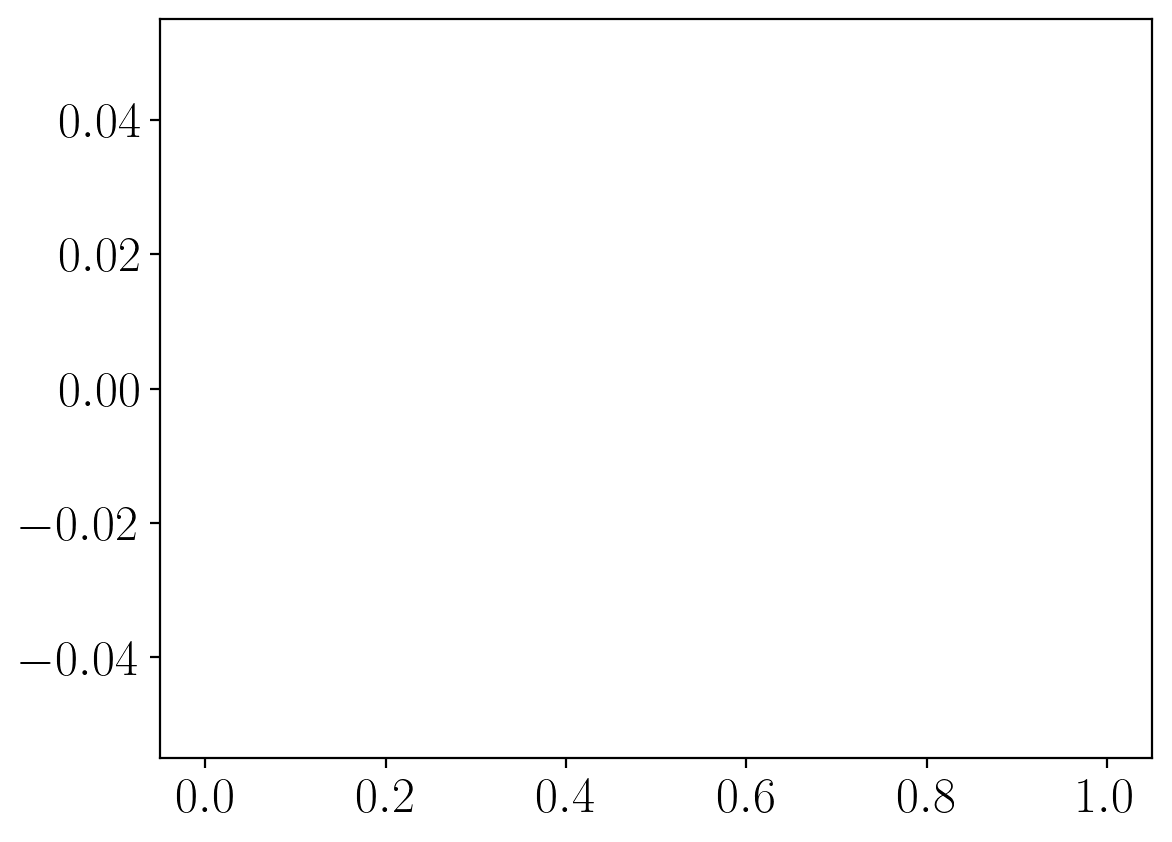

In [19]:
plt.hist(np.log((arr_t[:, keys=="4/a"]/run_systems[system_idx]["gap"][0]/(run_systems[system_idx]["gap"][1]/run_systems[system_idx]["gap"][0]))))

In [20]:
cfg

{'binary': {'m1': 1e-20,
  'm2': 1e-20,
  'd': 0.00257,
  'e': 0,
  'a': 1,
  'e_sys': 0,
  'phase': 0,
  'Omega': 0,
  'inc': 0},
 'n_secondary': 8,
 'secondary_0': {'m': 1.3728607339396024,
  'a': 0.011553729789749313,
  'e': 0.007796328148420293,
  'inc': 0.0,
  'omega': -2.242147050066274,
  'Omega': 1.5815606353722114},
 'secondary_1': {'m': 1.3336048791814283,
  'a': 0.015782139968449273,
  'e': 0.005754024778176803,
  'inc': 0.0,
  'omega': 2.2649579931867034,
  'Omega': 2.0375791719173835},
 'n_log': 1000,
 'integrator': 'whfast',
 'dt': 3.16e-05,
 't_end': 10000000.0,
 'name': 'sin_inj/TRAPPIST-1/2999',
 'm_star': 0.8097997812802267,
 'secondary_2': {'m': 0.3764150779540393,
  'a': 0.022394976295424307,
  'e': 0.008829018504784254,
  'inc': 0.0,
  'omega': -2.793232967170257,
  'Omega': 0.2723432767971099},
 'secondary_3': {'m': 0.6752885090320436,
  'a': 0.03091227312904521,
  'e': 0.0055626391141001715,
  'inc': 0.0,
  'omega': -2.9828841732243245,
  'Omega': -2.093161033119

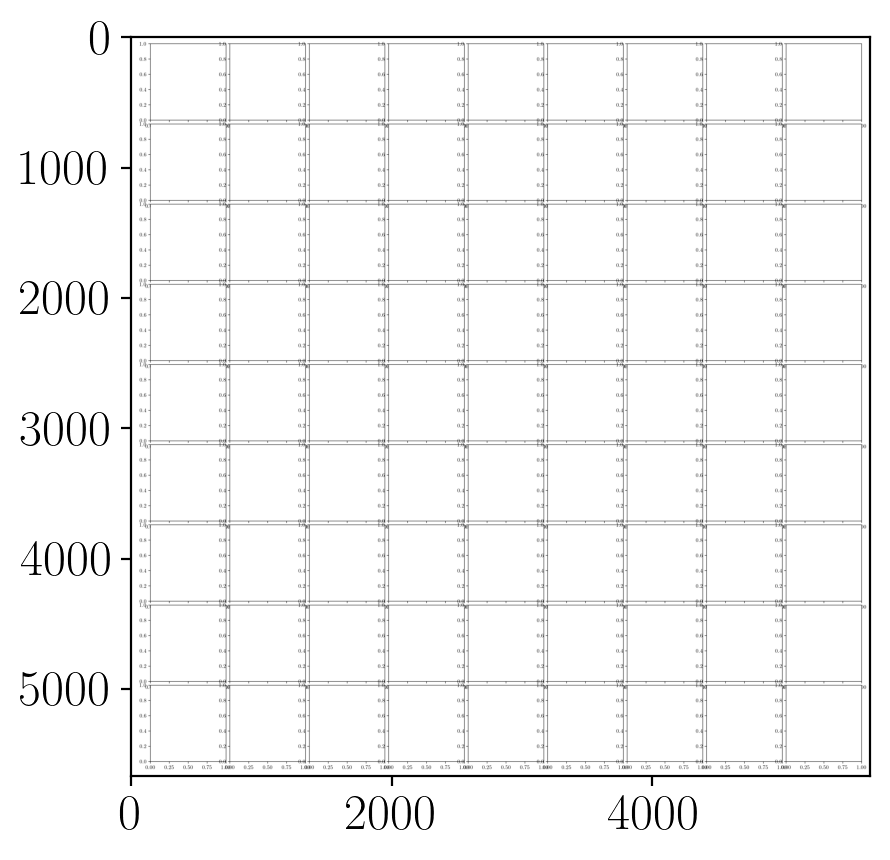

In [21]:
plt.imshow(mpimg.imread('../figs/corner_KOI-351_pmar_scat_None.png'))

In [22]:
arr[stable, :][:, idxs].shape

(1, 4)

In [23]:
idxs = np.array([("inc" not in key) and ("/e" not in key) for key in keys])



param_labels = np.char.replace(np.array(keys)[idxs], "_", "-")



# labels of the populations
listlablpopl = ['stable', 'not stable']

# number of populations
numbpopl = len(listlablpopl)


# number of features
numbfeat = np.sum(idxs)

# generate samples


# labels of the parameters
listlablpara = []
for k in range(numbfeat):
    listlablpara.append([param_labels[k], ''])

typepgrp = 'both'
    
j 
tdpy.plot_grid( [arr[stable, :][: ,idxs][:, :j], arr[np.logical_not(stable),:][:,idxs][:, :j]], listlablpara[:j], listlablpopl=listlablpopl, typeplottdim='scat', pathbase="../figs/corner")
# plt.savefig("../figs/corner.pdf")
# plt.show()

tdpy.util.plot_grid():
boolplotpies
True


AttributeError: 'list' object has no attribute 'ndim'

In [ ]:
import matplotlib
matplotlib.colors.to_rgba(listcolrpopl[1], 0.2)

In [ ]:
matplotlib.colors.to_rgba(listcolrpopl[u], 0.2))

In [ ]:
c = dict(cfg)
id(c)

In [ ]:
c["name"]

In [ ]:
cfg["name"] = "test"

In [ ]:
run_systems = np.load("../data/compact_systems_run_composite.npy", allow_pickle=True)
names = [sys["name"] for sys in run_systems]

In [ ]:
np.where(np.array(names) == "TOI-561")

In [ ]:
names